<a href="https://colab.research.google.com/github/habibsain/Index-Option/blob/main/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install nsepython

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import nsepython as ns
import datetime as dt
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

In [114]:
#d = yf.Ticker("NIFTY_FIN_SERVICE.NS")
#d.info['shortName'].replace(" ", "_")

'NIFTY_FIN_SERVICE'

In [115]:
tickers = ["^NSEI","^NSEBANK", "NIFTY_FIN_SERVICE.NS", "^BSESN"]
for tk in tickers:
  df = yf.download(tk, start = "2024-01-01", end = "2024-07-29", interval="1h")
  d= yf.Ticker(tk)
  d.info['shortName'].replace(" ", "_")
  df.to_csv(d.info['shortName'].replace(" ", "_")+".csv")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [124]:
data = pd.read_csv("NIFTY_FIN_SERVICE.csv")
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2024-01-01 09:15:00+05:30,21449.250000,21477.300781,21411.349609,21447.949219,21447.949219,0
1,2024-01-01 10:15:00+05:30,21447.199219,21514.849609,21440.250000,21501.550781,21501.550781,0
2,2024-01-01 11:15:00+05:30,21500.050781,21513.250000,21478.250000,21509.750000,21509.750000,0
3,2024-01-01 12:15:00+05:30,21508.599609,21514.099609,21473.199219,21491.949219,21491.949219,0
4,2024-01-01 13:15:00+05:30,21492.699219,21518.500000,21482.199219,21512.500000,21512.500000,0


<Axes: >

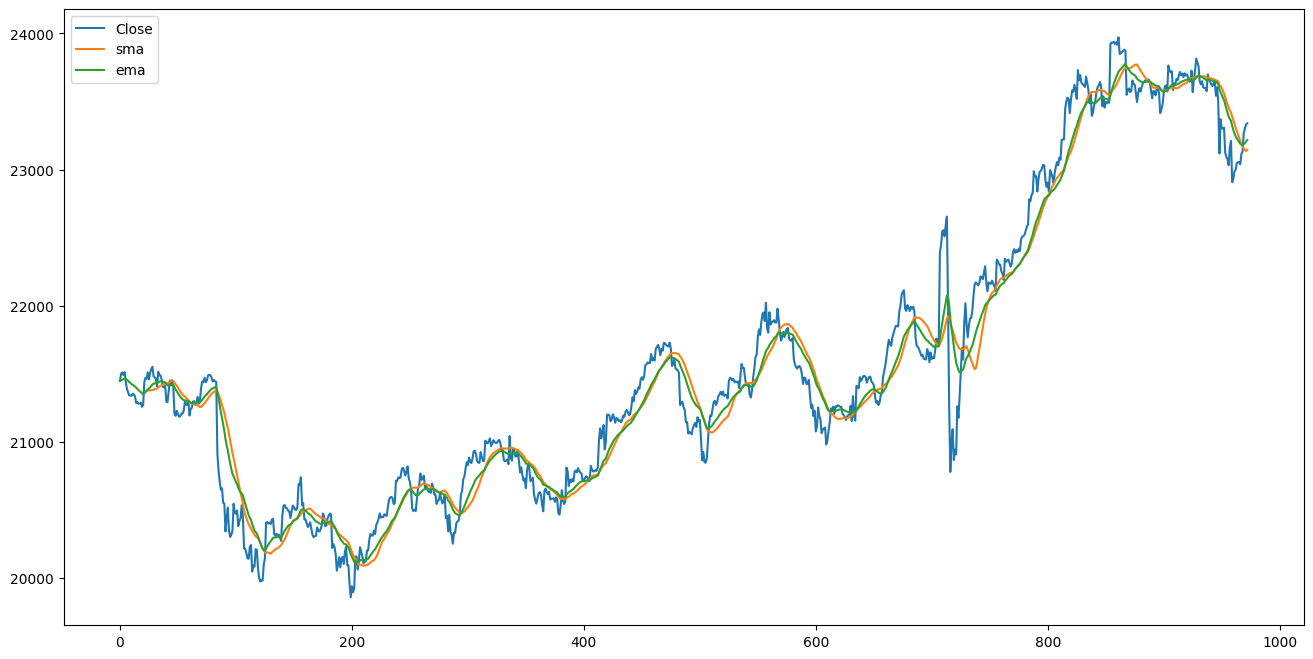

In [155]:
#plot
k[['Close', 'sma', 'ema']].plot( figsize = (16,8))

In [150]:
#indicators(period = 2d)
def get_sma(price, period = 24, column = 'sma'):
    return price.rolling(window = period).mean()

def get_ema(price, period = 24, column = 'ema'):
    return price.ewm(span = period, adjust = False).mean()
length =14
def get_rsi(price, period = 14, column = 'rsi'):
    delta = price.diff()
    up = delta.clip(lower = 0)
    down = -1 * delta.clip(upper = 0).abs()

    roll_up = up.ewm(span = period, adjust = False).mean()
    roll_down = down.ewm(span = period, adjust = False).mean()
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    # rsi = rsi.case_when([((roll_down == 0), 100), ((roll_up == 0), 0)])  # This alternative to np.select works only for pd.__version__ >= 2.2.0.
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    #assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi


In [151]:
k = data.copy()
k['sma'] = get_sma(k['Close'])
k['ema'] = get_ema(k['Close'])
k['rsi'] = get_rsi(k['Close'])
k.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,sma,ema,rsi
0,2024-01-01 09:15:00+05:30,21449.250000,21477.300781,21411.349609,21447.949219,21447.949219,0,NaN,21447.949219,NaN
1,2024-01-01 10:15:00+05:30,21447.199219,21514.849609,21440.250000,21501.550781,21501.550781,0,NaN,21452.237344,100.000000
2,2024-01-01 11:15:00+05:30,21500.050781,21513.250000,21478.250000,21509.750000,21509.750000,0,NaN,21456.838356,100.000000
3,2024-01-01 12:15:00+05:30,21508.599609,21514.099609,21473.199219,21491.949219,21491.949219,0,NaN,21459.647225,106.111632
4,2024-01-01 13:15:00+05:30,21492.699219,21518.500000,21482.199219,21512.500000,21512.500000,0,NaN,21463.875447,105.651524


In [152]:
k.tail()

,Datetime,Open,High,Low,Close,Adj Close,Volume,sma,ema,rsi
968,2024-07-26 11:15:00+05:30,23114.500000,23174.849609,23108.599609,23131.349609,23131.349609,0,23166.714518,23178.562225,600.577321
969,2024-07-26 12:15:00+05:30,23131.250000,23269.849609,23128.849609,23269.849609,23269.849609,0,23155.402018,23185.865215,188.310938
970,2024-07-26 13:15:00+05:30,23271.099609,23335.400391,23243.699219,23301.750000,23301.750000,0,23142.839518,23195.135998,172.452684
971,2024-07-26 14:15:00+05:30,23302.699219,23336.449219,23275.500000,23331.250000,23331.250000,0,23135.931152,23206.025118,160.802423
972,2024-07-26 15:15:00+05:30,23331.099609,23352.800781,23303.750000,23338.449219,23338.449219,0,23145.122803,23216.619046,158.168632
